Inspect the data inside CARLA (or NuScenes) dataset.

In [1]:
%matplotlib inline

import os
import sys
import json
from glob import glob
from timeit import default_timer as timer

import pandas as pd
import numpy as np
import scipy
import torch
import dill
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe

should_add_carlapath = False
if should_add_carlapath:
    PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
    sys.path.append(PYTHONAPI_EGG_PATH)
sys.path.append('../../../trajectron')
sys.path.append('../../../..')
sys.path.append('..')

import utility as util
import utility.doc
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

def make_continuous_copy(alpha):
    alpha = (alpha + np.pi) % (2.0 * np.pi) - np.pi
    continuous_x = np.zeros_like(alpha)
    continuous_x[0] = alpha[0]
    for i in range(1, len(alpha)):
        if not (np.sign(alpha[i]) == np.sign(alpha[i - 1])) and np.abs(alpha[i]) > np.pi / 2:
            continuous_x[i] = continuous_x[i - 1] + (
                    alpha[i] - alpha[i - 1]) - np.sign(
                (alpha[i] - alpha[i - 1])) * 2 * np.pi
        else:
            continuous_x[i] = continuous_x[i - 1] + (alpha[i] - alpha[i - 1])
    return continuous_x

def derivative_of(x, dt=1, radian=False):
    if radian:
        x = make_continuous_copy(x)
    if x[~np.isnan(x)].shape[-1] < 2:
        return np.zeros_like(x)
    dx = np.full_like(x, np.nan)
    dx[~np.isnan(x)] = np.gradient(x[~np.isnan(x)], dt)
    return dx

def trajectory_curvature(t):
    path_distance = np.linalg.norm(t[-1] - t[0])
    lengths = np.sqrt(np.sum(np.diff(t, axis=0) ** 2, axis=1))  # Length between points
    path_length = np.sum(lengths)
    if np.isclose(path_distance, 0.):
        return 0, 0, 0
    return (path_length / path_distance) - 1, path_length, path_distance

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

def node_to_df(node):
    columns = ['_'.join(t) for t in node.data.header]
    return pd.DataFrame(node.data.data, columns=columns)

def scene_to_df(scene):
    dfs = [node_to_df(node) for node in scene.nodes if repr(node.type) == 'VEHICLE']
    tmp_dfs = []
    for node, df in zip(scene.nodes, dfs):
        df.insert(0, 'node_id', str(node.id))
        df.insert(0, 'frame_id', range(len(df)))
        tmp_dfs.append(df)
    return pd.concat(tmp_dfs)

def scenes_to_df(scenes):
    dfs = []
    for scene in scenes:
        df = scene_to_df(scene)
        df['node_id'] = scene.name + '/' + df['node_id']
        # df[['position_x', 'position_y']] += np.array([scene.x_min, scene.y_min])
        dfs.append(df)
    return pd.concat(dfs)

Search datasaets

In [4]:
search_datasets = True
rootdir = "../../../.."
datadir = "*"
# datadir = "out"
glob(f"{rootdir}/{datadir}/*.pkl") if search_datasets else []

['../../../../notebooks/road_polygons.Town03.pkl',
 '../../../../cache/map_data.Town01.pkl',
 '../../../../cache/map_data.Town10HD.pkl',
 '../../../../cache/map_data.Town06.pkl',
 '../../../../cache/map_data.Town04.pkl',
 '../../../../cache/map_data.Town05.pkl',
 '../../../../cache/map_data.Town03.pkl',
 '../../../../cache/map_data.Town02.pkl',
 '../../../../cache/map_data.Town07.pkl',
 '../../../../carla_dataset_v3-1/v3-1_split1_val.pkl',
 '../../../../carla_dataset_v3-1/v3-1_split1_test.pkl',
 '../../../../carla_dataset_v3-1/v3-1_split1_train.pkl',
 '../../../../rawCarla-0.9.13-Town03/20220326_20-29-56_Town03.pkl',
 '../../../../rawCarla-0.9.13-Town03/20220326_19-45-40_Town03.pkl',
 '../../../../rawCarla-0.9.13-Town03/20220326_20-18-10_Town03.pkl',
 '../../../../rawCarla-0.9.13-Town03/20220326_20-35-50_Town03.pkl',
 '../../../../rawCarla-0.9.13-Town03/20220326_20-24-03_Town03.pkl',
 '../../../../carla_dataset_v4-1/v4-1_split1_train_modfm.pkl',
 '../../../../carla_dataset_v4-1/v4-1_sp

Load dataset

In [6]:
dataset_1 = util.AttrDict(
        path='../processed/nuScenes_test_full.pkl',
        name='nuscenes_test',
        has_augments=False)

dataset_2 = util.AttrDict(
        path=f"{ rootdir }/carla_v2_1_dataset/carla_train_v2_1_full.pkl",
        name='carla_train_v2_1',
        has_augments=True)

dataset_3 = util.AttrDict(
        path=f"{ rootdir }/carla_v2_1_dataset/carla_test_v2_1_full.pkl",
        name='carla_test_v2_1',
        has_augments=False)

dataset_4 = util.AttrDict(
        path=f"{ rootdir }/carla_v2_2_dataset/carla_train_v2_2_full.pkl",
        name='carla_train_v2_2',
        has_augments=True)

dataset_5 = util.AttrDict(
        path=f"{ rootdir }/carla_v2_2_dataset/carla_test_v2_2_full.pkl",
        name='carla_test_v2_2',
        has_augments=False)

dataset_6 = util.AttrDict(
        path=f"{ rootdir }/carla_v2_1_1_dataset/carla_train_v2_1_1_full.pkl",
        desc="CARLA synthesized dataset smaller sized",
        name="carla_train_v2_1_1",
        has_augments=True)

dataset_7 = util.AttrDict(
        path=f"{ rootdir }/carla_v3_0_1_dataset/carla_train_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        has_augments=True)

dataset_8 = util.AttrDict(
        path=f"{ rootdir }/v3-1_split1_train.pkl",
        name='v3-1',
        desc="CARLA synthesized dataset smaller sized with heading and occlusion fix",
        has_augments=True)

dataset_9 = util.AttrDict(
        path=f"{ rootdir }/carla_v3-1-1_dataset/v3-1-1_split1_train.pkl",
        name='v3-1-1',
        desc="CARLA synthesized dataset smaller sized with heading and occlusion fix",
        has_augments=True)

dataset_10 = util.AttrDict(
        path=f"{ rootdir }/carla_v3-1-1_dataset/v3-1-1_split1_train_modfm.pkl",
        name='v3-1-1 modfm',
        desc="CARLA synthesized dataset smaller sized with heading and occlusion fix",
        has_augments=True)

dataset_11 = util.AttrDict(
        path=f"{ rootdir }/carla_dataset_v4-1/v4-1_split1_train_modfm.pkl",
        name="v4-1",
        desc="CARLA 0.9.13 synthesized dataset all maps",
        has_augments=True)

dataset_12 = util.AttrDict(
        path=f"{ rootdir }/carla_dataset_v3-1-2/v3-1-2_split1_train_modfm.pkl",
        name="v3-1-2",
        desc="CARLA synthesized dataset with heading and occlusion fix",
        has_augments=True)

dataset_13 = util.AttrDict(
        path=f"{ rootdir }/carla_dataset_v3-1-2/v3-1-2_split1_val.pkl",
        name="v3-1-2",
        desc="CARLA synthesized dataset with heading and occlusion fix",
        has_augments=False)

dataset = dataset_13
with open(dataset.path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(f"Dataset {dataset.name} contains {len(eval_scenes)} scenes.")

Dataset v3-1-2 contains 60 scenes.


Inspect scene and nodes

In [4]:
# spill out 
scene = eval_scenes[0]
node = scene.nodes[0]
df = scene_to_df(scene)
f = lambda x: [*vars(x).keys()]

print("Environment name:", eval_env.name)
for _, scene in zip(range(10), eval_env.scenes):
    print("Scene name:", scene.name)

util.doc.results(
    "Environment keys:", f(eval_env),
    "Scene keys:", f(scene),
    "Node keys:", f(node),
    "Data columns:", [*df.columns]
)

Environment name: Town03
Scene name: Town06/ep016/agent4427/frame00004032
Scene name: Town04/ep009/agent2778/frame00009274
Scene name: Town05/ep012/agent3532/frame00007293
Scene name: Town10HD/ep022/agent5865/frame00001927
Scene name: Town04/ep009/agent2780/frame00009274
Scene name: Town03/ep002/agent1280/frame00003529
Scene name: Town07/ep026/agent5412/frame00002270
Scene name: Town03/ep000/agent1002/frame00002405
Scene name: Town10HD/ep023/agent5924/frame00002489
Scene name: Town04/ep006/agent2066/frame00006433
Environment keys:
['scenes', 'name', 'node_type_list', 'attention_radius', 'NodeType', 'robot_type', 'standardization', 'standardize_param_memo', '_scenes_resample_prop']

Scene keys:
['ego_initx', 'ego_inity', 'x_min', 'y_min', 'x_max', 'y_max', 'x_size', 'y_size', 'patch_box', 'patch_angle', 'canvas_size', 'homography', 'layer_names', 'map', 'timesteps', 'dt', 'name', 'nodes', 'robot', 'temporal_scene_graph', 'frequency_multiplier', 'description', 'aug_func', 'non_aug_scene'

### Plot scene

In [7]:
should_search = False
if should_search:
    f = lambda scene: scene.name == 'Town03/ep000/agent509/frame00253320'
    scene = util.filter_next(f, eval_scenes)
else:
    scene = eval_scenes[4]

aug_idx = 5
if dataset.has_augments:
    print( scene.augmented[aug_idx].patch_angle )

None


10 nodes in scene: 2791 2795 2808 2809 2945 2973 ego 2801 2852 2995


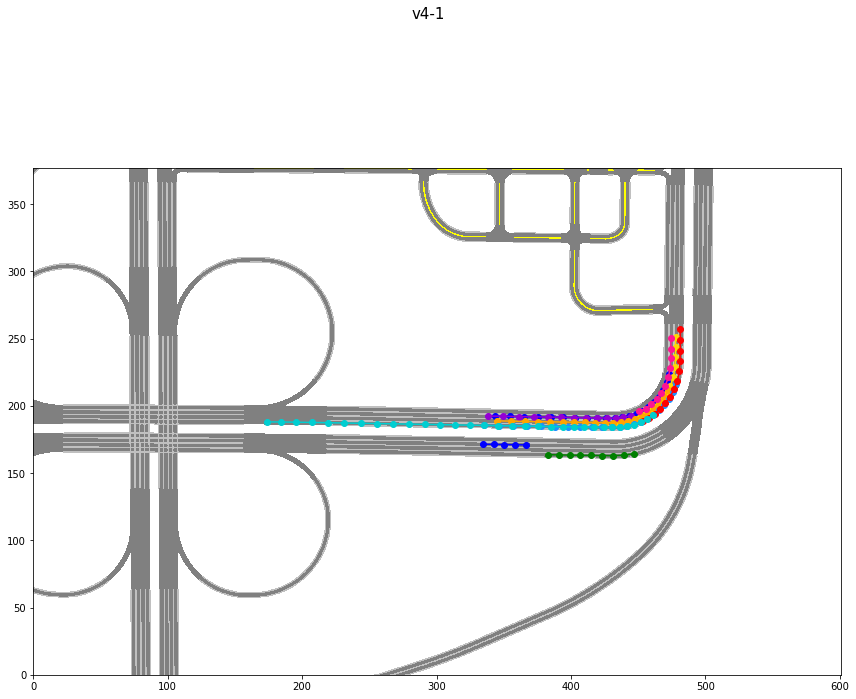

In [8]:
map_mask = scene.map['VEHICLE'].as_image()
# map_mask has shape (y, x, c)
road_bitmap = np.max(map_mask, axis=2)
road_div_bitmap = map_mask[..., 1]
lane_div_bitmap = map_mask[..., 2]

fig, ax = plt.subplots(figsize=(12,12))
extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
extent = (0, scene.x_size, 0, scene.y_size)
# Axes.imshow() expects (y, x, c)
ax.imshow(road_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'grey']))
ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))

scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
print(f"{len(node_ids)} nodes in scene: " + ' '.join(node_ids))

for idx, node_id in enumerate(node_ids):
# for idx, node_id in enumerate(node_ids[14:15]):
# for idx, node_id in enumerate( util.filter_to_list(lambda x: x == '594', node_ids) ):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values.T
    ax.plot(X[0], X[1], '-o', color=AGENT_COLORS[idx % NCOLORS])

ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()
fig.suptitle(dataset.name, fontsize=15)
None

### Inspect data statistics and tables

Look at scene/node frequency multiplier

22995 nodes; min frequency 1 ; max frequency 25; sum of frequencies 30567
1023 nodes with frequencies > 1; min frequency 5 ; max frequency 25; sum of frequencies 8595


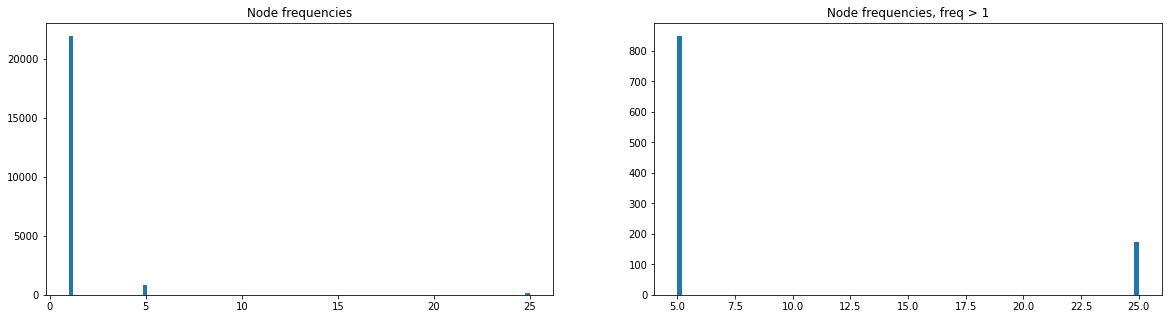

In [9]:
fms = []
fms_n1 = []
for scene in eval_scenes:
    fms.extend([node.frequency_multiplier for node in scene.nodes])
    fms_n1.extend([node.frequency_multiplier for node in scene.nodes if node.frequency_multiplier != 1])

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].hist(fms, bins=100)
axes[0].set_title("Node frequencies")
axes[1].hist(fms_n1, bins=100)
axes[1].set_title("Node frequencies, freq > 1")
out = "{} nodes; min frequency {} ; max frequency {}; sum of frequencies {}".format(
    len(fms), np.min(fms), np.max(fms), np.sum(fms)
)
print(out)
out = "{} nodes with frequencies > 1; min frequency {} ; max frequency {}; sum of frequencies {}".format(
    len(fms_n1), np.min(fms_n1), np.max(fms_n1), np.sum(fms_n1)
)
print(out)

In [49]:
# Collect nodes indexed by frequency
node = None
node_by_fm = {}
for scene in eval_scenes:
    for node in scene.nodes:
        fm = node.frequency_multiplier
        if fm in node_by_fm:
            node_by_fm[fm].append(node)
        else:
            node_by_fm[fm] = [node]
k = [*node_by_fm.keys()]
k.sort()
print("list of frequencies", k)

list of frequencies [1, 5, 25]


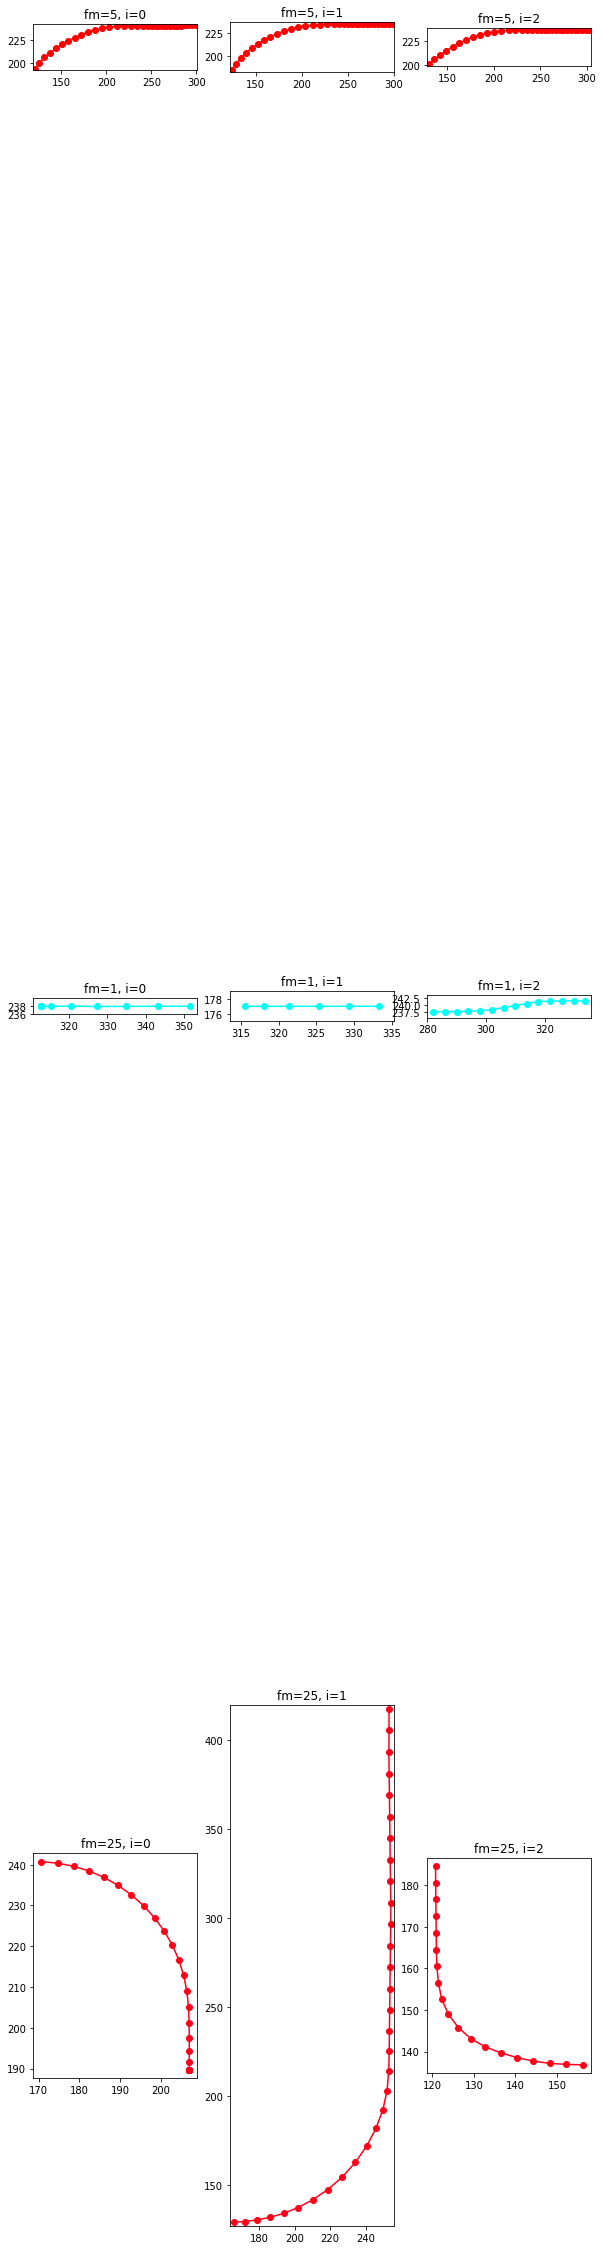

In [50]:
# Plot example nodes for each freqency
N = len(node_by_fm)
I = 3
fm_colors = cm.hsv(np.linspace(0, 1, N))
fig, axes = plt.subplots(N, I, figsize=(10, 50))
for n, fm in enumerate(node_by_fm.keys()):
    for i in range(I):
        node = node_by_fm[fm][i]
        node_df = node_to_df(node)
        X = node_df[['position_x', 'position_y']].values
        X = X.T
        axes[n, i].plot(*X, '-o', color=fm_colors[n])
        axes[n, i].set_aspect('equal')
        axes[n, i].set_xlim([ np.min(X[0]) - 2 , np.max(X[0]) + 2 ])
        axes[n, i].set_ylim([ np.min(X[1]) - 2 , np.max(X[1]) + 2 ])
        axes[n, i].set_title(f"fm={fm}, i={i}")


From trajectory_curvature() 0.12070812193171943


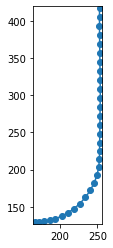

In [52]:
# Plot a specific nodes for a specific freqency
node = node_by_fm[25][1]
node_df = node_to_df(node)
X = node_df[['position_x', 'position_y']].values
print('From trajectory_curvature()', trajectory_curvature(X)[0])
X = X.T
plt.plot(*X, '-o')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlim([ np.min(X[0]) - 2 , np.max(X[0]) + 2 ])
ax.set_ylim([ np.min(X[1]) - 2 , np.max(X[1]) + 2 ])
None

In [ ]:
# below doesn't work
# dx, dy = derivative_of(X[0]),  derivative_of(X[1])
# ddx, ddy = derivative_of(dx),  derivative_of(dy)
# curvature = np.linalg.norm(np.stack([ddx, ddy]), axis=0)
# print(curvature)
# print('curvature', np.max(curvature))
# Based on:
# https://en.wikipedia.org/wiki/Curvature#Curvature_of_a_graph
# Also:
# https://stackoverflow.com/questions/47972932/detecting-curvature-of-a-plot

Inspecting tabulated data

In [10]:
print("scene nodes:", *scene.nodes)
node = scene.nodes[1]
scene_df = scene_to_df(scene)
node_df = scene_df[scene_df['node_id'] == node.id]
print("tabular data for node ID", node.id)
node_df

scene nodes: VEHICLE/4247 VEHICLE/4337 VEHICLE/4345 VEHICLE/4348 VEHICLE/4353 VEHICLE/4359 VEHICLE/ego VEHICLE/4361 VEHICLE/4370 VEHICLE/4323 VEHICLE/4340 VEHICLE/4382 VEHICLE/4273 VEHICLE/4357 VEHICLE/4296 VEHICLE/4288 VEHICLE/4232 VEHICLE/4379 VEHICLE/4325 VEHICLE/4287 VEHICLE/4318 VEHICLE/4376 VEHICLE/4271
tabular data for node ID 4337


,frame_id,node_id,position_x,position_y,velocity_x,velocity_y,acceleration_x,acceleration_y,heading_x,heading_y,heading_°,heading_d°,velocity_norm,acceleration_norm
0,0,4337,213.436737,182.356018,-9.898590,-0.034962,1.830841,0.005577,-0.999994,-0.003537,-3.138056,1.347560e-04,9.898652,1.830850
1,1,4337,208.487442,182.338537,-8.983170,-0.032173,1.618042,0.004769,-0.999994,-0.003604,-3.137989,1.129180e-04,8.983227,1.618049
2,2,4337,204.453568,182.323845,-8.280548,-0.030192,-0.371719,-0.001959,-0.999993,-0.003650,-3.137943,4.394216e-05,8.280603,0.371725
3,3,4337,200.206894,182.308345,-9.354889,-0.034132,-1.146561,-0.004329,-0.999993,-0.003648,-3.137945,-1.864213e-06,9.354951,1.146569
4,4,4337,195.098679,182.289713,-9.427109,-0.034521,1.294113,0.004463,-0.999993,-0.003648,-3.137945,9.347695e-05,9.427172,1.294121
5,5,4337,190.779785,182.273824,-8.060776,-0.029669,1.072983,0.003916,-0.999993,-0.003741,-3.137851,1.597897e-06,8.060830,1.072990
6,6,4337,187.037903,182.260044,-8.354126,-0.030605,-1.516953,-0.005276,-0.999993,-0.003649,-3.137943,-9.214537e-05,8.354182,1.516962
7,7,4337,182.425659,182.243218,-9.577728,-0.034945,-0.319260,-0.000663,-0.999993,-0.003649,-3.137943,2.663161e-07,9.577792,0.319260
8,8,4337,177.460175,182.225100,-8.673386,-0.031268,3.835388,0.014635,-0.999993,-0.003650,-3.137943,-1.283644e-04,8.673442,3.835416
9,9,4337,173.752274,182.211950,-5.742340,-0.020309,3.736404,0.013536,-0.999994,-0.003521,-3.138072,-1.288970e-04,5.742376,3.736429


In [11]:
scenes_df = scenes_to_df(eval_env.scenes)
velocity_norm = scenes_df["velocity_norm"].values
acceleration_norm = scenes_df["acceleration_norm"].values
heading_d = scenes_df["heading_d°"].values
# group by node_id and select first
# scenes_df.groupby("node_id").first()

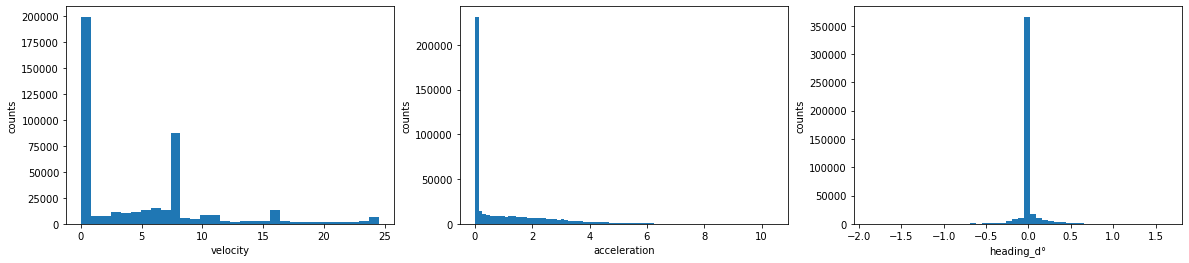

In [12]:
# Histograph of dataset wide values
# By default, Trajectron++ nuScenes preprocessing assumes that
# position (x,y) compponents are mean 0, std 80
# velocity (x,y,norm) compponents are mean 0, std 15
# acceleration (x,y,norm) compponents are mean 0, std 15
# heading d° are mean 0, std 1
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(131)
ax.hist(velocity_norm, bins=30)
ax.set_xlabel("velocity")
ax.set_ylabel("counts")
ax = fig.add_subplot(132)
ax.hist(acceleration_norm, bins=80)
ax.set_xlabel("acceleration")
ax.set_ylabel("counts")
ax = fig.add_subplot(133)
ax.hist(heading_d, bins=50)
ax.set_xlabel("heading_d°")
ax.set_ylabel("counts")
None

### Plotting tabular data

Plotting scene information, including that of augmented scene

Plot velocity

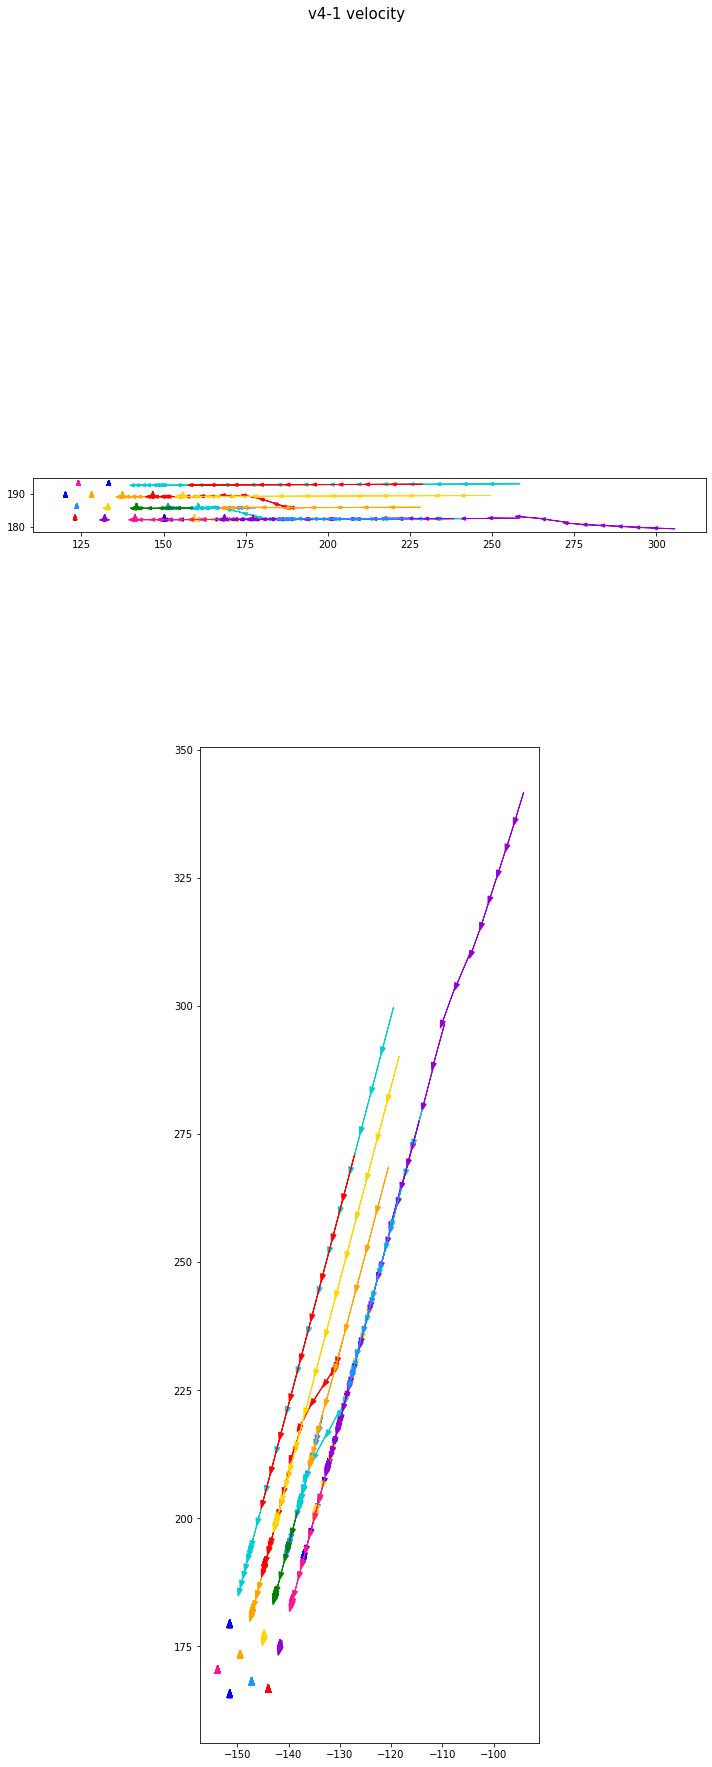

In [13]:
def plot_xy_vel_to_map(ax, scene):
    scene_df = scene_to_df(scene)
    node_ids = scene_df['node_id'].unique()
    for idx, node_id in enumerate(node_ids):
        node_df = scene_df[scene_df['node_id'] == node_id]
        X = node_df[['position_x', 'position_y']].values
        V = node_df[['velocity_x', 'velocity_y']].values
        n_subsample = 1
        start = 0
        scale = 0.5
        for x, v in zip(X[start::n_subsample], V[start::n_subsample]):
            ax.arrow(x[0], x[1], scale*v[0], scale*v[1],
                    head_width=1,
                    color=AGENT_COLORS[idx % NCOLORS])
    ax.set_aspect('equal')

if dataset.has_augments:
    fig, axes = plt.subplots(2, 1, figsize=(10,25))
    axes = axes.ravel()
    plot_xy_vel_to_map(axes[0], scene)
    aug_scene = scene.augmented[aug_idx]
    plot_xy_vel_to_map(axes[1], aug_scene)
else:
    fig, ax = plt.subplots(figsize=(12,12))
    plot_xy_vel_to_map(ax, scene)

fig.suptitle(f"{dataset.name} velocity", fontsize=15)
fig.tight_layout()

Plot acceleration

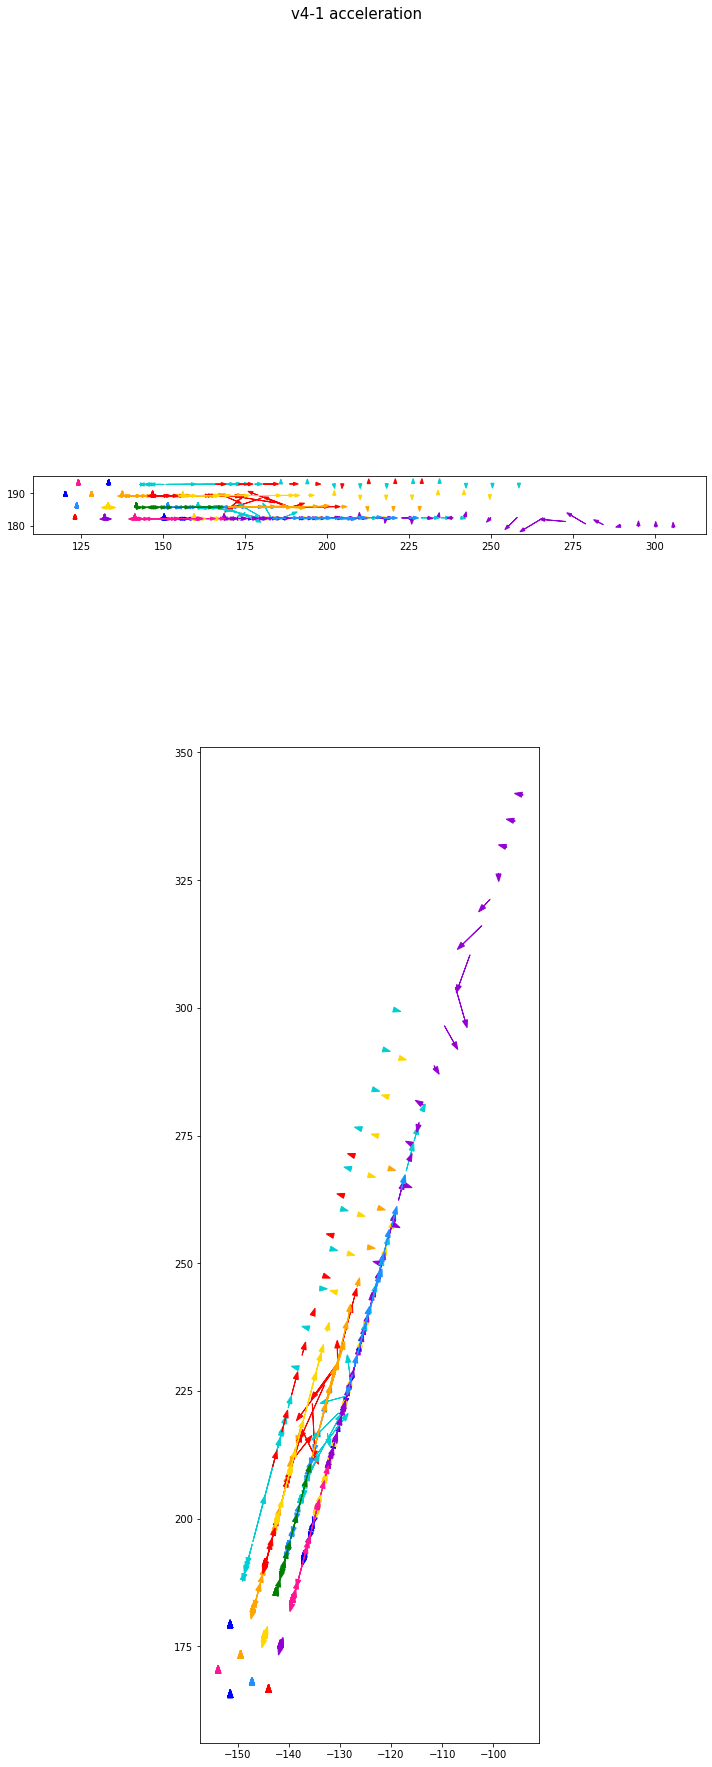

In [14]:
def plot_xy_acc_to_map(ax, scene):
    scene_df = scene_to_df(scene)
    node_ids = scene_df['node_id'].unique()
    for idx, node_id in enumerate(node_ids):
        node_df = scene_df[scene_df['node_id'] == node_id]
        X = node_df[['position_x', 'position_y']].values
        A = 2 * node_df[['acceleration_x', 'acceleration_y']].values
        n_subsample = 1
        start = 0
        for x, a in zip(X[start::n_subsample], A[start::n_subsample]):
            ax.arrow(x[0], x[1], a[0], a[1],
                    head_width=1,
                    color=AGENT_COLORS[idx % NCOLORS])
    ax.set_aspect('equal')

if dataset.has_augments:
    fig, axes = plt.subplots(2, 1, figsize=(10,25))
    axes = axes.ravel()
    plot_xy_acc_to_map(axes[0], scene)
    aug_scene = scene.augmented[aug_idx]
    plot_xy_acc_to_map(axes[1], aug_scene)
else:
    fig, ax = plt.subplots(figsize=(12,12))
    plot_xy_acc_to_map(ax, scene)

fig.suptitle(f"{dataset.name} acceleration", fontsize=15)
fig.tight_layout()

Plot heading in (x, y) components

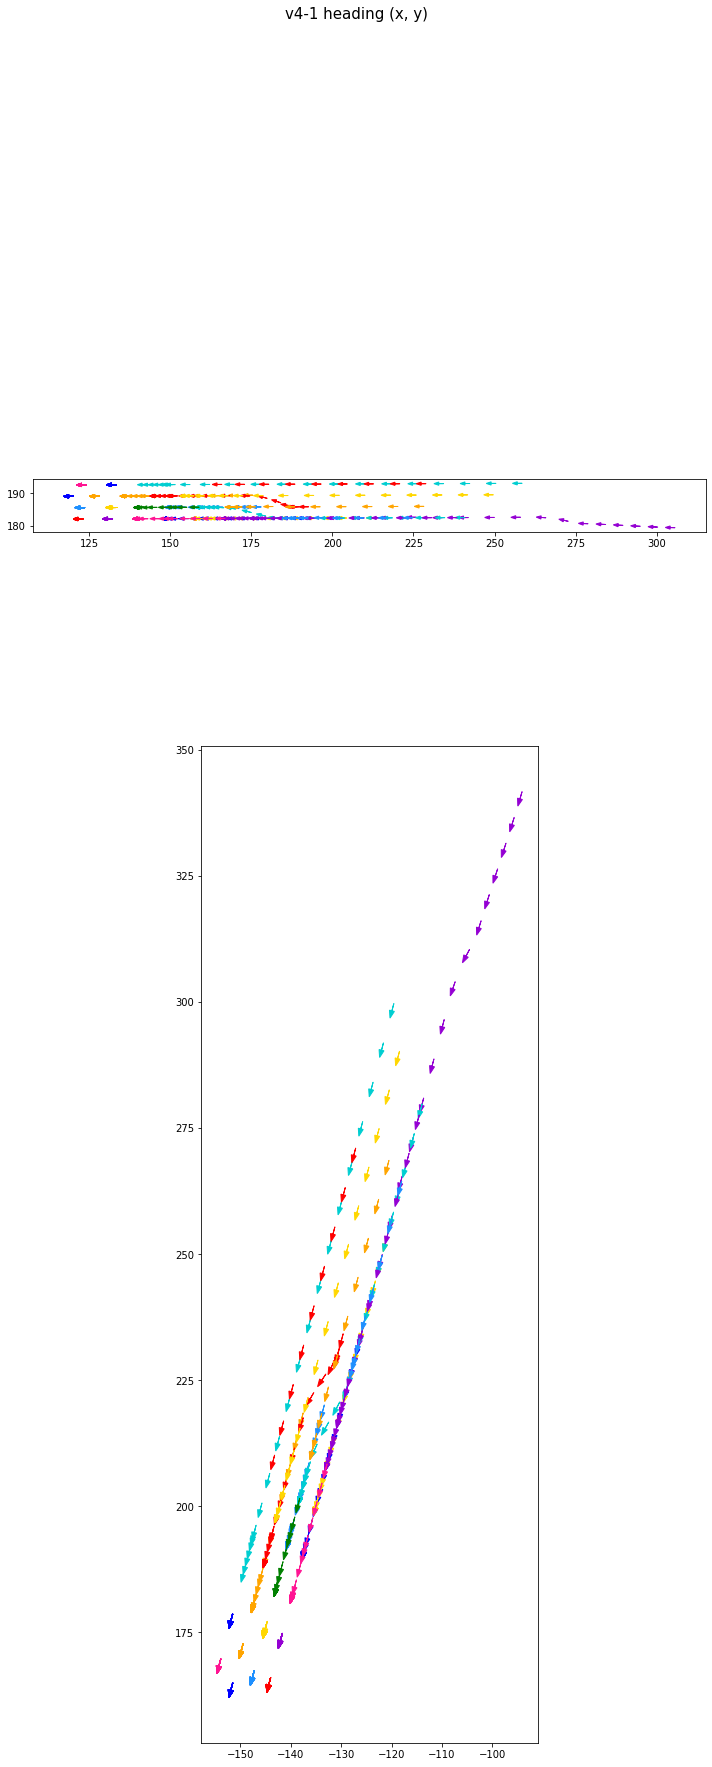

In [15]:
def plot_xy_yaw_to_map(ax, scene):
    scene_df = scene_to_df(scene)
    node_ids = scene_df['node_id'].unique()
    for idx, node_id in enumerate(node_ids):
        node_df = scene_df[scene_df['node_id'] == node_id]
        X = node_df[['position_x', 'position_y']].values
        H = 3 * node_df[['heading_x', 'heading_y']].values
        n_subsample = 1
        start = 0
        scale = 0.5
        for x, h in zip(X[start::n_subsample], H[start::n_subsample]):
            ax.arrow(x[0], x[1], scale*h[0], scale*h[1],
                    head_width=1,
                    color=AGENT_COLORS[idx % NCOLORS])
    ax.set_aspect('equal')

if dataset.has_augments:
    fig, axes = plt.subplots(2, 1, figsize=(10,25))
    axes = axes.ravel()
    plot_xy_yaw_to_map(axes[0], scene)
    aug_scene = scene.augmented[aug_idx]
    plot_xy_yaw_to_map(axes[1], aug_scene)
else:
    fig, ax = plt.subplots(figsize=(12,12))
    plot_xy_yaw_to_map(ax, scene)

fig.suptitle(f"{dataset.name} heading (x, y)", fontsize=15)
fig.tight_layout()

Plot heading in radians

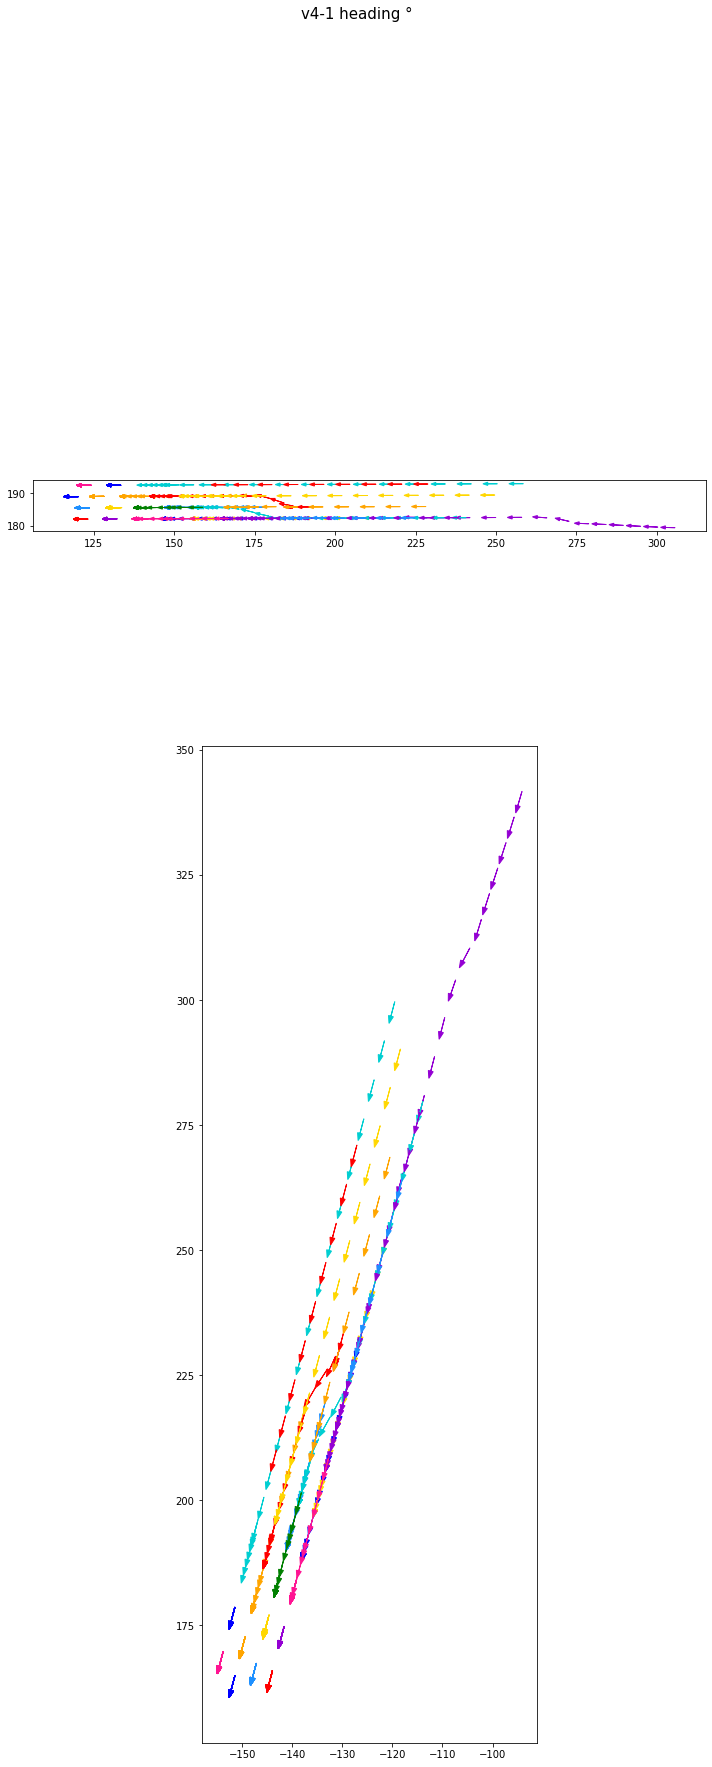

In [16]:
def plot_rad_yaw_to_map(ax, scene):
    scene_df = scene_to_df(scene)
    node_ids = scene_df['node_id'].unique()
    for idx, node_id in enumerate(node_ids):
        node_df = scene_df[scene_df['node_id'] == node_id]
        X = node_df[['position_x', 'position_y']].values
        hs = node_df['heading_°'].values
        cos_hs = 3 * np.cos(hs)
        sin_hs = 3 * np.sin(hs)
        n_subsample = 1
        start = 0
        for x, cos_h, sin_h in zip(X[start::n_subsample],
                cos_hs[start::n_subsample], sin_hs[start::n_subsample]):
            ax.arrow(x[0], x[1], cos_h, sin_h,
                    head_width=1,
                    color=AGENT_COLORS[idx % NCOLORS])
    ax.set_aspect('equal')

if dataset.has_augments:
    fig, axes = plt.subplots(2, 1, figsize=(10,25))
    axes = axes.ravel()
    plot_rad_yaw_to_map(axes[0], scene)
    aug_scene = scene.augmented[aug_idx]
    plot_rad_yaw_to_map(axes[1], aug_scene)
else:
    fig, ax = plt.subplots(figsize=(12,12))
    plot_rad_yaw_to_map(ax, scene)

fig.suptitle(f"{dataset.name} heading °", fontsize=15)
fig.tight_layout()

Plot heading over time

In [43]:
def rad_yaw(scene):
    scene_df = scene_to_df(scene)
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    axes = axes.ravel()

    node_dict = {str(node.id): node for node in scene.nodes}
    scene_df = scene_to_df(scene)
    node_ids = scene_df['node_id'].unique()
    for idx, node_id in enumerate(node_ids):
        node = node_dict[node_id]
        node_df = scene_df[scene_df['node_id'] == node_id]
        Hd = node_df['heading_°'].values
        # heading_d° is the derivate of heading
        H = node_df['heading_d°'].values
        N = np.arange(node.first_timestep, node.first_timestep + len(node_df))
        axes[0].plot(N, Hd, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[1].plot(N, H, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)

    axes[0].set_ylabel('heading_°')
    axes[1].set_ylabel('heading_d°')
    for ax in axes:
        ax.set_xlabel('timestep')
    fig.suptitle(f"{dataset.name} heading °, d°", fontsize=15)

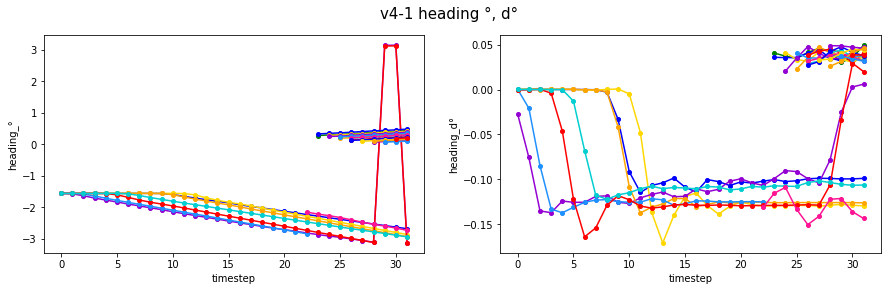

In [44]:
rad_yaw(scene)

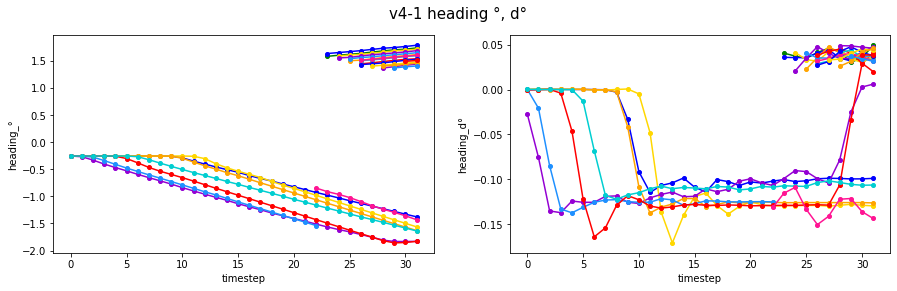

In [45]:
if dataset.has_augments:
    aug_scene = scene.augmented[aug_idx]
    rad_yaw(aug_scene)

Plot velocity and acceleration in separate coordinates

In [93]:
def plot_xy_vel_acc_yaw(scene):
    fig, axes = plt.subplots(4, 2, figsize=(15,15))
    axes = axes.ravel()

    node_dict = {str(node.id): node for node in scene.nodes}
    scene_df = scene_to_df(scene)
    node_ids = scene_df['node_id'].unique()
    for idx, node_id in enumerate(node_ids):
        node = node_dict[node_id]
        node_df = scene_df[scene_df['node_id'] == node_id]
        Vnorm = node_df['velocity_norm'].values
        Anorm = node_df['acceleration_norm'].values
        X = node_df[['position_x', 'position_y']].values.T
        V = node_df[['velocity_x', 'velocity_y']].values.T
        A = node_df[['acceleration_x', 'acceleration_y']].values.T
        H = node_df[['heading_x', 'heading_y']].values.T
        N = np.arange(node.first_timestep, node.first_timestep + len(node_df))
        axes[0].plot(N, Vnorm, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[1].plot(N, Anorm, color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[2].plot(N, V[0], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[3].plot(N, V[1], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[4].plot(N, A[0], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[5].plot(N, A[1], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[6].plot(N, H[0], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)
        axes[7].plot(N, H[1], color=AGENT_COLORS[idx % NCOLORS], marker='o', markersize=4)

    axes[0].set_ylabel('velocity')
    axes[1].set_ylabel('acceleration')
    axes[2].set_ylabel('velocity_x')
    axes[3].set_ylabel('velocity_y')
    axes[4].set_ylabel('acceleration_x')
    axes[5].set_ylabel('acceleration_y')
    axes[6].set_ylabel('heading_x')
    axes[7].set_ylabel('heading_y')
    for ax in axes:
        ax.set_xlabel('timestep')
    # fig.tight_layout()
    fig.suptitle(dataset.name, fontsize=15)

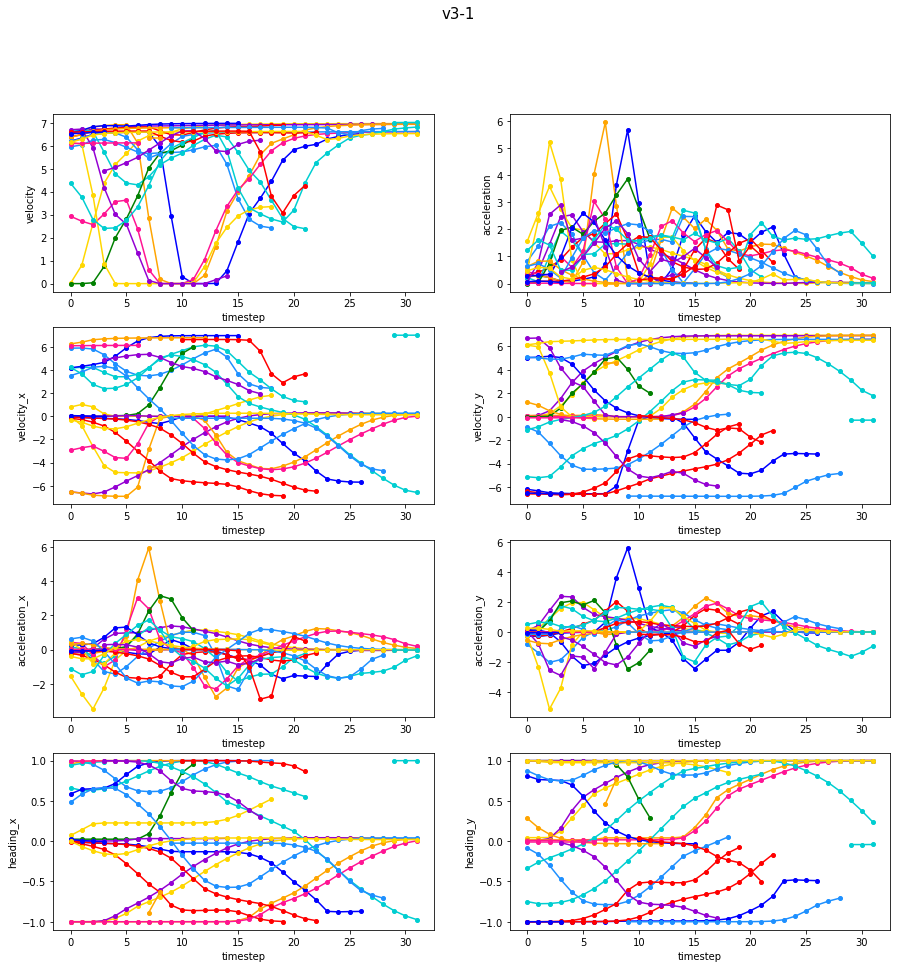

In [94]:
plot_xy_vel_acc_yaw(scene)

In [95]:
if dataset.has_augments:
    aug_scene = scene.augmented[aug_idx]
    plot_xy_vel_acc_yaw(aug_scene)

## Scratch

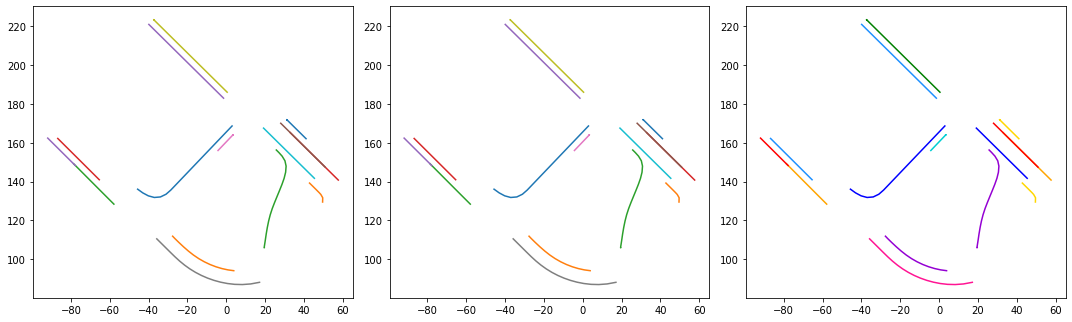

In [19]:
# Figuring out how to render trajectrories in dataset
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.ravel()
ax = axes[0]
for node in scene.nodes:
    xy = node.data.data[:, :2]
    ax.plot(xy[:, 0], xy[:, 1])

ax = axes[1]
for node in scene.nodes:
    columns = ['_'.join(t) for t in node.data.header]
    df = pd.DataFrame(node.data.data, columns=columns)
    X = df[['position_x', 'position_y']].values.T
    ax.plot(X[0], X[1])

ax = axes[2]
scene_df = scene_to_df(scene)
node_ids = scene_df['node_id'].unique()
for idx, node_id in enumerate(node_ids):
    node_df = scene_df[scene_df['node_id'] == node_id]
    X = node_df[['position_x', 'position_y']].values.T
    ax.plot(X[0], X[1], color=AGENT_COLORS[idx % NCOLORS])

for ax in axes:
    ax.set_aspect('equal')
fig.tight_layout()